In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from   tensorflow.keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from   sklearn.linear_model import LinearRegression
import warnings
import pandas as pd

As with the exercise on Shapley values, I again use the MNIST dataset, so that I can compare the two approaches of Shapley and LIME.

In [34]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1) / 255
x_test = x_test.reshape(10000, 28, 28, 1) / 255

In order to make the comparison fair, I again use the same complex, black-box neural network for the model.

In [35]:
tf.keras.utils.set_random_seed(42)
mnist_model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

mnist_model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/2
1875/1875 [==============================] - 246s 129ms/step - loss: 0.1775 - accuracy: 0.9474 - val_loss: 0.0548 - val_accuracy: 0.9816
Epoch 2/2
1875/1875 [==============================] - 234s 125ms/step - loss: 0.0745 - accuracy: 0.9779 - val_loss: 0.0256 - val_accuracy: 0.9908


In [170]:
def find_important_segments(img_index, n_segments, n_important_features):
    # looking at just a single image
    test_image = x_test[img_index]
    # segment that image into n_segments number of superpixels
    segments = skimage.segmentation.slic(test_image, n_segments=n_segments, compactness=0.1)
    num_segments = np.unique(segments).shape[0]
    
    # plot the segmented boundaries that will each represent one "feature" for LIME
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(skimage.segmentation.mark_boundaries(np.squeeze(test_image), segments, mode="subpixel"))

    # we will calculate 500 perturbed images, acting as the "surrogate" data points
    # each perturbed image will have a different permutation of segments turned on or off
    num_perturb = 500
    np.random.seed(42)
    perturbations = np.random.binomial(1, 0.5, size=(500, num_segments))
    def perturb_image(img, perturbation, segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
            mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    perturbed_images = np.asarray([perturb_image(test_image, perturbation, segments) for perturbation in perturbations])
    # predict on the complex black-box model
    predictions = mnist_model.predict(perturbed_images, verbose=0)

    # Each image is represented as a vector. We simply find the vector distance between the perturbed image, and the original image.
    # This distance is then inverted using the kernel function, so larger weights are given to more similar perturbed images.
    all_segments = np.ones(num_segments)[np.newaxis,:]
    distances = sklearn.metrics.pairwise_distances(perturbations, all_segments, metric='cosine').ravel()
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))

    # A linear model is fitted to the local neighbourhood around the original image
    # We weight the different samples (perturbed images) by their similarity to the original image
    linear_model = LinearRegression()
    linear_model.fit(X=perturbations, y=predictions[:, y_test[img_index]], sample_weight=weights);

    # We take the top features, e.g. segments, and display only these on the plot.
    # These are the segments that were the most important to the prediction.
    top_features = np.argsort(linear_model.coef_)[-n_important_features:] 
    mask = np.zeros(num_segments) 
    mask[top_features] = True   
    axes[1].imshow(perturb_image(test_image, mask, segments), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


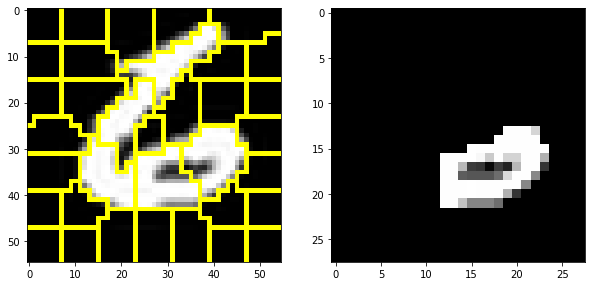

In [178]:
find_important_segments(img_index=-1, n_segments=50, n_important_features=2)

For the number 6, the circle on the bottom right was the most important for the prediction of this class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


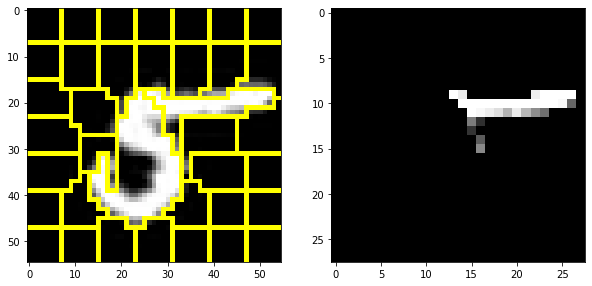

In [176]:
find_important_segments(img_index=-2, n_segments=50, n_important_features=1)

For the 5, the most important segment for prediction is the horizontal line across the top of the number.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of segments: 64


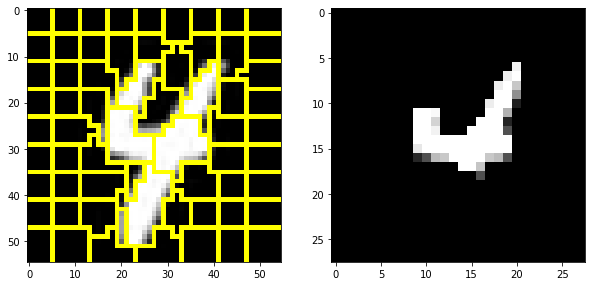

In [169]:
find_important_segments(img_index=-3, n_segments=75, n_important_features=3)

The three most important segments for the prediction of the number 4 are also displayed.

For all 3 numbers, it is the criticial white segments that were most important for the prediction of the corresponding class.